# TREINO COM FLATTEN E DATASET IMAGEM 64x64x3 CROSS VALIDATION CALLBACKS

In [1]:
#Import libraries
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Rescaling, BatchNormalization, Conv2D, MaxPooling2D, SpatialDropout2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint
from numpy import load
from tensorboard import version
from keras.preprocessing import image
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import os, datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.datasets
import gc

In [2]:
#Import and check tensorflow version

print(tf.__version__)

#check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

print("tensorboard.version.VERSION: ", version.VERSION)

2.14.0
Num GPUs Available:  1
Num GPUs Available:  1
tensorboard.version.VERSION:  2.14.1


In [3]:
!git clone 'https://github.com/Luis-P-Duarte/Projeto-IA-22-23-Malware-Android.git'

Cloning into 'Projeto-IA-22-23-Malware-Android'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 227 (delta 26), reused 12 (delta 12), pack-reused 188
Receiving objects: 100% (227/227), 130.71 MiB | 36.87 MiB/s, done.
Resolving deltas: 100% (100/100), done.
Updating files: 100% (67/67), done.


In [4]:
!pip install rarfile

In [5]:
import rarfile

# Đường dẫn đến tệp .rar trên Google Drive
rar_path = '/content/Projeto-IA-22-23-Malware-Android/Images/64x64.rar'

# Giải nén tệp .rar
with rarfile.RarFile(rar_path, 'r') as rf:
    rf.extractall('/content/data')

In [6]:
directory='/content/data/64x64'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    label_mode='int',
    seed=1337,
    image_size=(64,64),
    batch_size= None,
)


Found 16621 files belonging to 5 classes.


In [10]:
import math

# Tính toán số lượng mẫu cần giữ lại (20%)
num_samples = len(train_ds)
num_samples_to_keep = math.ceil(num_samples * 0.2)

# Lấy ra 20% dữ liệu
filtered_train_ds = train_ds.take(num_samples_to_keep)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
image_array = []
label_array = []

for element in filtered_train_ds:

    image_array.append(np.asarray(element[0]))
    label_array.append(np.asarray(element[1]))

image_array = np.asarray(image_array)
label_array = np.asarray(label_array)

print(image_array.shape)
print(label_array.shape)


(3325, 64, 64, 3)
(3325,)


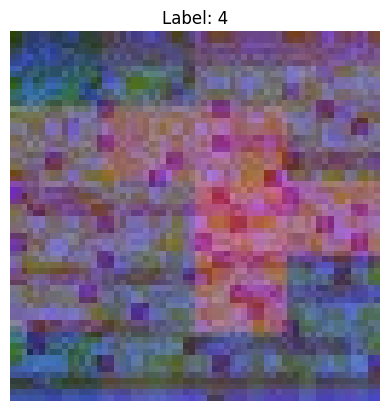

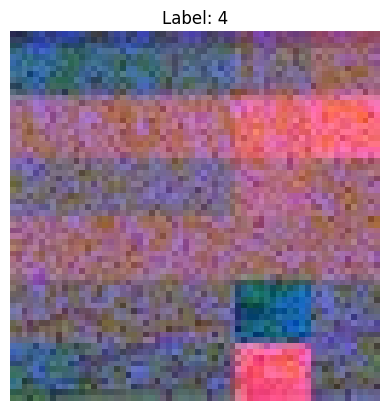

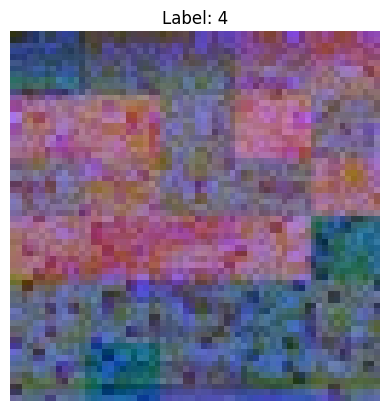

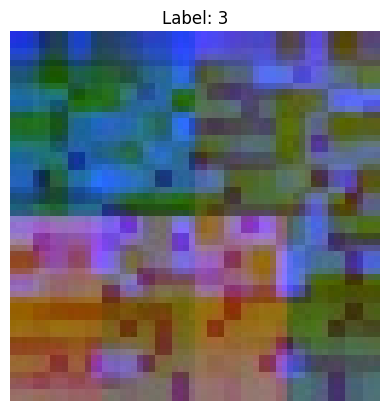

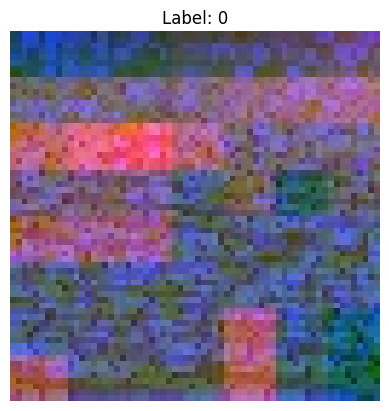

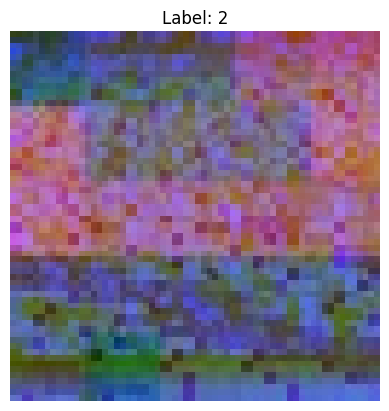

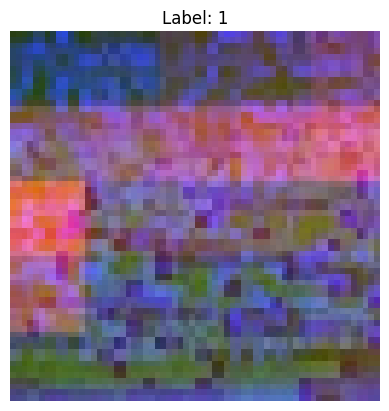

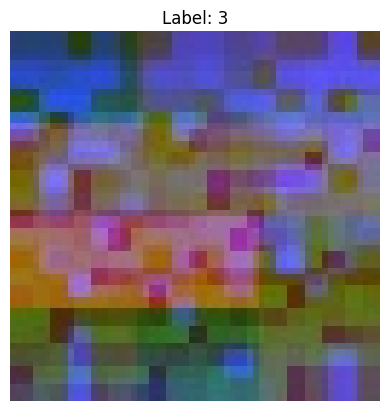

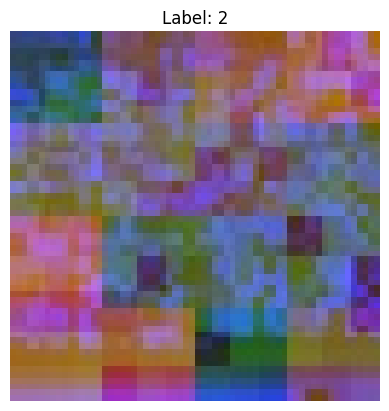

In [13]:
for i in range(9):
    image = image_array[i]
    label = label_array[i]

    # Hiển thị hình ảnh và nhãn tương ứng
    plt.imshow(image.astype('uint8'))
    plt.title('Label: {}'.format(label))
    plt.axis('off')
    plt.show()

In [14]:
model_x_train, model_x_val, model_y_train, model_y_val = train_test_split(image_array, label_array,
                                                                          test_size=0.3, random_state=42)

model_x_val, model_x_test, model_y_val, model_y_test = train_test_split(model_x_val, model_y_val, test_size=0.5)

print('Data for training:')
print(model_x_train.shape)
print(model_y_train.shape)

print('Data for validation:')
print(model_x_val.shape)
print(model_y_val.shape)

print('Data for testing:')
print(model_x_test.shape)
print(model_y_test.shape)

Data for training:
(2327, 64, 64, 3)
(2327,)
Data for validation:
(499, 64, 64, 3)
(499,)
Data for testing:
(499, 64, 64, 3)
(499,)


## MODELO

In [15]:
gc.collect()

with tf.device('/GPU:0'):

    model = Sequential()
    ##normalizaçao [-1,1]
    model.add(Rescaling(1./127.5, offset=-1, input_shape=(64, 64, 3)))
    model.add(Conv2D(filters=128, kernel_size=(2), strides=(1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2), padding='valid', strides=(1)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(5,activation='softmax'))

    model.compile(
        optimizer='adam',
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])

    #Saved models path
    model_name = 'conv2D_holdout_64x64'
    save_path_best_model = '../Models/Holdout/Conv2D_64x64/' + model_name + '.hdf5'

    # CREATE CALLBACKS
    checkpoint_val_acc = tf.keras.callbacks.ModelCheckpoint(save_path_best_model,
                                                    monitor='val_accuracy', verbose=0,
                                                    save_best_only=True, mode='max')

    callbacks_list = [checkpoint_val_acc]


    # Fit data to model - uses x_train to train and validate
    model_history = model.fit(model_x_train,model_y_train,validation_data=(model_x_val,model_y_val),
                        verbose=2, batch_size=160, callbacks=callbacks_list, epochs=10)

    gc.collect()

    #load best model from fold
    best_model_holdout = load_model(save_path_best_model)

    # Generate generalization metrics - uses x_test to validate and predict
    model_scores = best_model_holdout.evaluate(model_x_val,model_y_val, verbose=0)

    # Calculate predicted labels for the test set
    model_y_pred = np.argmax(best_model_holdout.predict(model_x_test), axis=-1)

    # Calculate precision, recall, and F1 score
    model_accuracy = accuracy_score(model_y_test, model_y_pred)
    model_precision = precision_score(model_y_test, model_y_pred, average='macro')
    model_recall = recall_score(model_y_test, model_y_pred, average='macro')
    model_f1 = f1_score(model_y_test, model_y_pred, average='macro')
    model_cm = confusion_matrix(model_y_test, model_y_pred)

    gc.collect()

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 - 35s - loss: 23.9996 - accuracy: 0.4710 - val_loss: 8.1298 - val_accuracy: 0.6453 - 35s/epoch - 2s/step
Epoch 2/10
15/15 - 17s - loss: 2.8512 - accuracy: 0.6678 - val_loss: 1.2001 - val_accuracy: 0.7635 - 17s/epoch - 1s/step
Epoch 3/10
15/15 - 18s - loss: 0.7359 - accuracy: 0.8002 - val_loss: 0.5143 - val_accuracy: 0.8417 - 18s/epoch - 1s/step
Epoch 4/10
15/15 - 2s - loss: 0.4054 - accuracy: 0.8749 - val_loss: 0.4690 - val_accuracy: 0.8176 - 2s/epoch - 145ms/step
Epoch 5/10
15/15 - 21s - loss: 0.2804 - accuracy: 0.9093 - val_loss: 0.3493 - val_accuracy: 0.8938 - 21s/epoch - 1s/step
Epoch 6/10
15/15 - 2s - loss: 0.1981 - accuracy: 0.9441 - val_loss: 0.3346 - val_accuracy: 0.8938 - 2s/epoch - 149ms/step
Epoch 7/10
15/15 - 2s - loss: 0.1570 - accuracy: 0.9609 - val_loss: 0.3478 - val_accuracy: 0.8758 - 2s/epoch - 143ms/step
Epoch 8/10
15/15 - 16s - loss: 0.1217 - accuracy: 0.9759 - val_loss: 0.3172 - val_accuracy: 0.8998 - 16s/epoch - 1s/step
Epoch 9/10
15/15 - 2s - loss: 0.0927 - 

In [16]:
print('\n----------------------------------------------------------')
print(f'Score: Eval {model.metrics_names[0]} of {round(model_scores[0],5)}; Eval {model.metrics_names[1]} of {round(model_scores[1]*100,5)}%')
print(f'> Accuracy: {round(model_accuracy*100,5)}%')
print(f'> Precision: {round(model_precision*100,5)}%')
print(f'> Recall: {round(model_recall*100,5)}%')
print(f'> F1 Score: {round(model_f1*100,5)}%')


----------------------------------------------------------
Score: Eval loss of 0.31717; Eval accuracy of 89.97996%
> Accuracy: 87.57515%
> Precision: 85.01875%
> Recall: 84.42944%
> F1 Score: 84.71206%


Text(0.5, 1.0, 'Confusion Matrix for Model')

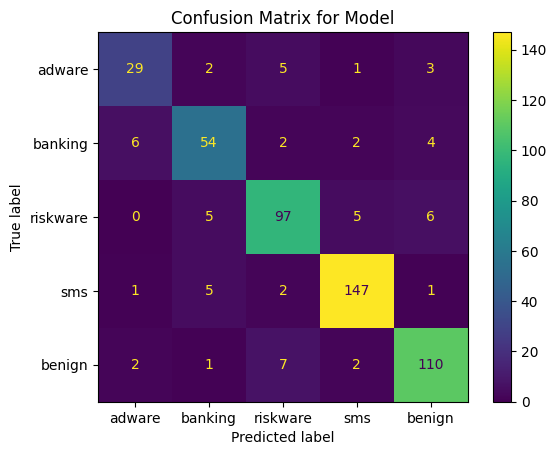

In [17]:
#normalize confusion matrix between 0 and 1
#cm = cm / cm.max()

#classes: 0 - adware, 1 - banking, 2 - riskware, 3 - sms, 4 - benign
classes = ['adware',  'banking', 'riskware', 'sms', 'benign']

model_cm_display = ConfusionMatrixDisplay(model_cm,display_labels=classes)
model_cm_display.plot()
model_cm_display.ax_.set_title(f'Confusion Matrix for Model')

## GRAFICOS TEM DE SER FEITOS MANUALMENTE

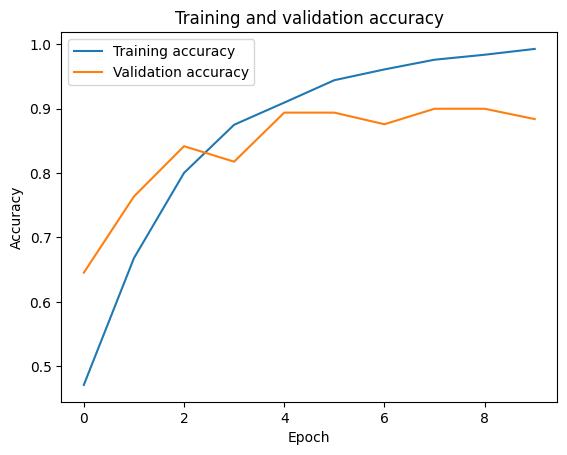

In [18]:
train_acc = model_history.history['accuracy']
train_loss = model_history.history['loss']
val_acc = model_history.history['val_accuracy']
val_loss = model_history.history['val_loss']

#plot accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

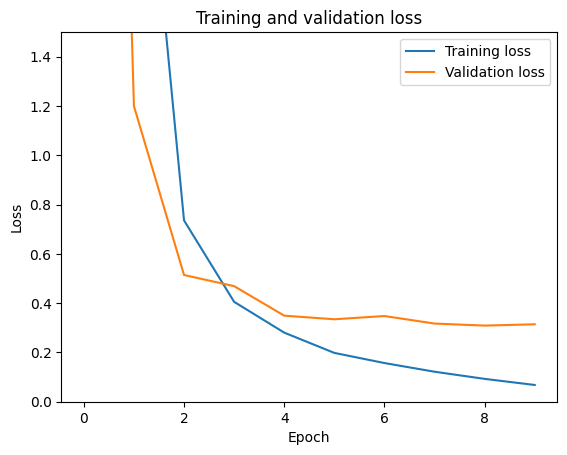

In [19]:
train_acc = model_history.history['accuracy']
train_loss = model_history.history['loss']
val_acc = model_history.history['val_accuracy']
val_loss = model_history.history['val_loss']

#plot loss
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1.5)
plt.legend()
plt.show()